# RNN - OCR

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import words
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## 1. Dataset

In [37]:
# nltk.download('words')
word_list = words.words()
print("Number of words in nltk corpus: ", len(word_list))
words_10 = [word for word in word_list if len(word) < 11]
selected_words = random.sample(words_10, 100000)
selected_words = [word.lower() for word in selected_words]
print("Examples: \n", selected_words[:10])


Number of words in nltk corpus:  236736
Examples: 
 ['feminism', 'lewis', 'wrongness', 'seascout', 'sozzly', 'senility', 'hemoscope', 'flitter', 'redispute', 'ungifted']


In [38]:
font_scale = 1.25
font_thickness = 2
font = cv2.FONT_HERSHEY_SIMPLEX

images_of_words = []

for i, word in enumerate(selected_words):
    img = np.ones((64, 256, 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(word, font, font_scale, font_thickness)[0]
    text_width, text_height = text_size
    x = (img.shape[1] - text_width) // 2
    y = (img.shape[0] + text_height) // 2
    cv2.putText(img, word, (x, y), font, font_scale, (0, 0, 0), font_thickness)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images_of_words.append(img)
    
images_of_words = np.array(images_of_words).astype(np.float32) / 255
print("Done")


Done


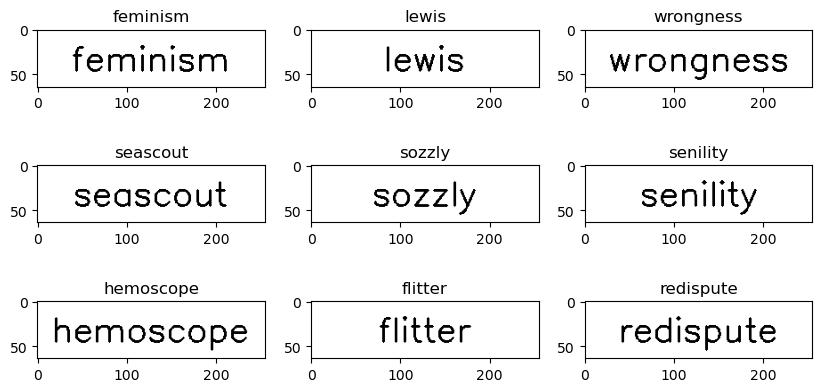

In [39]:
# show some examples
plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_of_words[i], cmap='gray')
    plt.title(selected_words[i])
plt.show()

In [40]:
# split the data into train test and validation

train_images = images_of_words[:80000]
test_images = images_of_words[80000:90000]
val_images = images_of_words[90000:]

train_words = selected_words[:80000]
test_words = selected_words[80000:90000]
val_words = selected_words[90000:]

print("Number of training images: ", len(train_images))
print("Number of test images: ", len(test_images))
print("Number of validation images: ", len(val_images))


Number of training images:  80000
Number of test images:  10000
Number of validation images:  10000


In [62]:
# convert images to 1 channel -> to tensors and make data loader

class WordsDataset(Dataset):
    def __init__(self, images, selected_words):
        self.images = images
        self.selected_words = selected_words
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.selected_words[idx]
        # list ascii values - a is 1
        label = [ord(ch) - 96 for ch in label]
        label = torch.tensor(label, dtype=torch.float32)
        return img, label


train_dataset = WordsDataset(train_images, train_words)
test_dataset = WordsDataset(test_images, test_words)
val_dataset = WordsDataset(val_images, val_words)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)




Data shape:  torch.Size([1, 64, 256])
Label:  tensor([[21., 14., 18., 15., 23.,  5., 12.,  5.,  4.]])


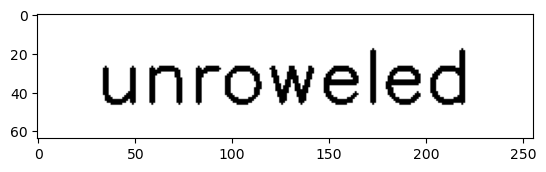

In [ ]:
# print shape of data
for data, label in val_loader:
    print("Data shape: ", data.shape)
    plt.imshow(data[0], cmap='gray')
    print("Label: ", label)
    break

## 2. Architecture

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN model for extracting features from images
# RNN model for predicting the words

class CNN_RNN(nn.Module):
    def __init__(self, num_classes=27, hidden_size=16, num_layers=1, dropout=0.0, batch_norm=False):
        super(CNN_RNN, self).__init__()

        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.batch_norm = batch_norm

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),    # 1x64x256 -> 16x64x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),     # 16x64x256 -> 16x32x128
            nn.Conv2d(16, 16, kernel_size=5, padding=2),    # 16x32x128 -> 16x32x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 16x32x128 -> 16x16x64
        )

        # 64 time steps
        # 16*16 features = 256 features at each time step
        
        self.rnn = nn.RNN(input_size=16*16, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        batch_size, C, H, W = x.size()
        x = self.cnn(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        # print(x.shape)
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = x.view(batch_size, x.size(1), -1)
        # print(x.shape)
        x, _ = self.rnn(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)

        return x


In [44]:
for data, label in train_loader:
    data = data.to(device)
    model = CNN_RNN().to(device)
    output = model(data)
    print("Output shape: ", output.shape)
    print(output)
    pred = torch.argmax(output, dim=2)
    print("Predicted shape: ", pred.shape)
    print(pred)
    print("Label shape: ", label.shape)
    print(label)
    break

Output shape:  torch.Size([1, 64, 27])
tensor([[[-0.4128, -0.2019, -0.3187,  ...,  0.2798, -0.3564, -0.3373],
         [-0.4495, -0.1311, -0.2547,  ...,  0.3149, -0.1782, -0.2623],
         [-0.4861, -0.1601, -0.2405,  ...,  0.3215, -0.1546, -0.2726],
         ...,
         [-0.4684, -0.1636, -0.2531,  ...,  0.3977, -0.1847, -0.2440],
         [-0.4770, -0.1344, -0.2258,  ...,  0.3925, -0.1885, -0.2520],
         [-0.4879, -0.0243, -0.2279,  ...,  0.3889, -0.1939, -0.1370]]],
       grad_fn=<ViewBackward0>)
Predicted shape:  torch.Size([1, 64])
tensor([[23, 16, 16, 16, 16, 16, 16, 17, 17, 24, 17, 17, 17, 16, 17, 17, 24, 17,
         16, 17, 24, 17, 17, 17, 17, 17, 24, 17, 17, 17, 17, 17, 24, 17, 24, 17,
         17, 17, 17, 17, 17, 16, 17, 17, 16, 17, 17, 16, 17, 17, 17, 17, 24, 17,
         24, 16, 17, 17, 16, 16, 16, 16, 16, 16]])
Label shape:  torch.Size([1, 10])
tensor([[ 1., 12., 12.,  5.,  7.,  5.,  1.,  2., 12.,  5.]])


## 3. Training

In [45]:
def decode_predictions(output):
    decoded = []
    for seq in output:
        pred = []
        prev_char = None
        for char in seq:
            if char != prev_char and char != 0:  # avoid blanks and repetitions
                pred.append(char)
            prev_char = char
        decoded.append(pred)
    return decoded


def compute_average_correct(predictions, labels):
    total_correct = 0
    total_characters = 0

    for pred, label in zip(predictions, labels):
        min_len = min(len(pred), len(label))
        correct = sum(1 for p, l in zip(pred[:min_len], label[:min_len]) if p == l)
        total_correct += correct
        total_characters += len(label)
    
    return total_correct / len(labels) if labels else 0  # Averaged over the batch



In [46]:
cnn_rnn = CNN_RNN().to(device)

criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(cnn_rnn.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)  # 1 x 64 x 27
            output = output.permute(1, 0, 2) # 1 x 64 x 27 -> 64 x 1 x 27
            output = nn.functional.log_softmax(output, dim=2)  # 64 x 1 x 27 -> 64 x 1 x 27
            # print("idhar",output.shape)
            # print(output)
            input_lengths = torch.full((data.size(0),), output.size(0), dtype=torch.int32)
            target_lengths = torch.full((data.size(0),), label.size(1), dtype=torch.int32)
            loss = criterion(output, label, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            output = output.permute(1, 0, 2)
            output = nn.functional.log_softmax(output, dim=2)
            input_lengths = torch.full((data.size(0),), output.size(0), dtype=torch.int32)
            target_lengths = torch.full((data.size(0),), label.size(1), dtype=torch.int32)
            loss = criterion(output, label, input_lengths, target_lengths)
            val_loss += loss.item()

            preds = torch.argmax(output, dim=2).permute(1, 0).cpu().numpy()
            decoded_preds = decode_predictions(preds)
            decoded_labels = label.cpu().numpy().tolist()

            all_preds.extend(decoded_preds)
            all_labels.extend(decoded_labels)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = compute_average_correct(decoded_preds, decoded_labels)
        val_accuracies.append(val_accuracy)


        print("Epoch: {} Train Loss: {} Val Loss: {} Val Accuracy: {}".format(epoch+1, train_loss, val_loss, val_accuracy))
    
    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train(cnn_rnn, train_loader, val_loader, criterion, optimizer, num_epochs=1)

100%|██████████| 80000/80000 [09:44<00:00, 136.79it/s]


Epoch: 1 Train Loss: 3.2546555500388146 Val Loss: 3.2526442382097245 Val Accuracy: 0.0


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(val_accuracies, label='Val Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()


In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    examples = []
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            output = output.permute(1, 0, 2)
            output = nn.functional.log_softmax(output, dim=2)
            input_lengths = torch.full((data.size(0),), output.size(0), dtype=torch.int32)
            target_lengths = torch.full((data.size(0),), label.size(1), dtype=torch.int32)
            loss = criterion(output, label, input_lengths, target_lengths)
            test_loss += loss.item()

            preds = torch.argmax(output, dim=2).permute(1, 0).cpu().numpy()
            decoded_preds = decode_predictions(preds)
            decoded_labels = label.cpu().numpy().tolist()

            examples.append((data[0].cpu().numpy(), decoded_preds[0], decoded_labels[0]))
            
    test_loss /= len(test_loader)
    test_accuracy = compute_average_correct(decoded_preds, decoded_labels)

    return test_loss, test_accuracy, examples

test_loss, test_accuracy, examples = test(cnn_rnn, test_loader, criterion)

print("Test Loss: {} Test Accuracy: {}".format(test_loss, test_accuracy))


Test Loss: 3.248316403055191 Test Accuracy: 0.0


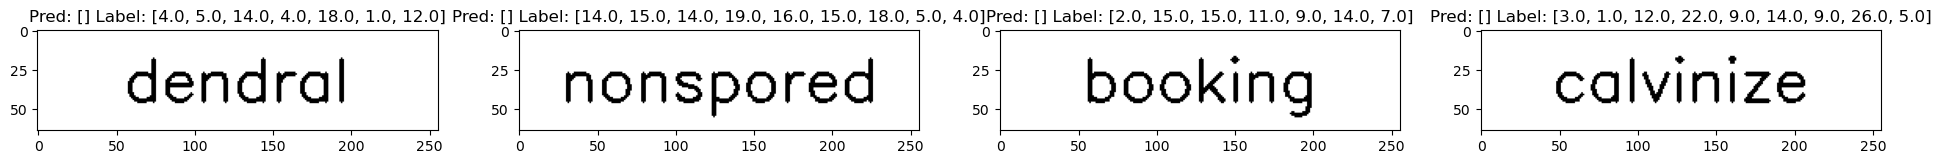

In [53]:
# show some predictions (5)

plt.figure(figsize=(30, 10))
for i in range(4):
    plt.subplot(2, 5, i + 1)
    img, pred, label = examples[i]
    plt.imshow(img, cmap='gray')
    plt.title("Pred: {} Label: {}".format(pred, label))

In [65]:
# compare with random baseline (randomly generated character sequences of same length as the label)

random_accuracy = 0.0
for pred, label in zip(examples, test_words):
    random_pred = [random.randint(1, 26) for _ in range(len(label))]
    random_accuracy += sum(1 for p, l in zip(random_pred, label) if p == l) / len(label)

random_accuracy /= len(examples)
print("Random Accuracy: ", random_accuracy)

Random Accuracy:  0.0
